In [10]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import pyarrow.dataset as ds
import pyarrow as pa
import gc
import logging
import os
from datetime import datetime
import psutil
from tqdm import tqdm
import traceback

In [12]:
class BatchProcessor:
    def __init__(self, data_dir, batch_size=100000):
        self.data_dir = data_dir
        self.batch_size = batch_size
        self.demand_path = os.path.join(data_dir, 'demand.parquet')
        self.weather_path = os.path.join(data_dir, 'weather.parquet')
        self.metadata_path = os.path.join(data_dir, 'metadata.parquet')
        
    def get_parquet_info(self, path):
        """Get information about parquet file"""
        dataset = pq.ParquetFile(path)
        return {
            'num_row_groups': dataset.num_row_groups,
            'schema': dataset.schema,
            'metadata': dataset.metadata
        }
    
    def process_demand_batch(self, row_group_idx):
        """Process a single row group from demand data"""
        pf = pq.ParquetFile(self.demand_path)
        
        # Read one row group
        table = pf.read_row_group(row_group_idx)
        batch_df = table.to_pandas()
        
        # Basic processing
        batch_df['hour'] = batch_df['timestamp'].dt.hour
        batch_df['day_of_week'] = batch_df['timestamp'].dt.dayofweek
        
        return batch_df
    
    def get_batch_dates(self):
        """Get unique dates from the demand data"""
        pf = pq.ParquetFile(self.demand_path)
        unique_dates = set()
        
        # Sample timestamps from each row group
        for i in range(pf.num_row_groups):
            table = pf.read_row_group(i, columns=['timestamp'])
            df = table.to_pandas()
            dates = df['timestamp'].dt.date.unique()
            unique_dates.update(dates)
        
        return sorted(list(unique_dates))
    
    def process_by_date(self, start_date, end_date, output_dir):
        """Process data day by day"""
        os.makedirs(output_dir, exist_ok=True)
        start_date = pd.Timestamp(start_date)
        end_date = pd.Timestamp(end_date)
        
        # Convert timestamps to datetime
        date_range = pd.date_range(start_date, end_date)
        total_processed = 0
        
        for date in tqdm(date_range, desc="Processing dates"):
            try:
                # Read demand data for this date
                demand_df = pd.read_parquet(
                    self.demand_path,
                    filters=[
                        ('timestamp', '>=', date),
                        ('timestamp', '<', date + pd.Timedelta(days=1))
                    ]
                )
                
                if demand_df.empty:
                    print(f"No demand data for {date.date()}")
                    continue
                
                # Read corresponding weather data
                weather_df = pd.read_parquet(
                    self.weather_path,
                    filters=[
                        ('timestamp', '>=', date),
                        ('timestamp', '<', date + pd.Timedelta(days=1))
                    ]
                )
                
                # Process in building chunks to manage memory
                unique_buildings = demand_df['unique_id'].unique()
                chunk_size = 10  # Process 10 buildings at a time
                
                for i in range(0, len(unique_buildings), chunk_size):
                    building_chunk = unique_buildings[i:i + chunk_size]
                    
                    # Filter data for this building chunk
                    chunk_demand = demand_df[demand_df['unique_id'].isin(building_chunk)].copy()
                    
                    # Merge with weather
                    merged_data = pd.merge(
                        chunk_demand,
                        weather_df,
                        on='timestamp',
                        how='left'
                    )
                    
                    # Create features
                    merged_data = self.create_features(merged_data)
                    
                    # Save chunk
                    output_path = os.path.join(
                        output_dir,
                        f'processed_{date.strftime("%Y%m%d")}_{i//chunk_size:03d}.parquet'
                    )
                    merged_data.to_parquet(
                        output_path,
                        engine='pyarrow',
                        compression='snappy',
                        index=False
                    )
                    
                    total_processed += len(merged_data)
                    
                    # Clean up
                    del merged_data, chunk_demand
                    gc.collect()
                
                # Clean up date-level data
                del demand_df, weather_df
                gc.collect()
                
                # Log progress
                memory_usage = psutil.Process(os.getpid()).memory_info().rss / 1024 / 1024
                print(f"Processed {date.date()}. Memory usage: {memory_usage:.2f} MB")
                
            except Exception as e:
                print(f"Error processing {date.date()}: {str(e)}")
                traceback.print_exc()
                continue
        
        return total_processed
    
    def create_features(self, df):
        """Create features for a batch of data"""
        # Time features
        df['hour'] = df['timestamp'].dt.hour
        df['day_of_week'] = df['timestamp'].dt.dayofweek
        df['month'] = df['timestamp'].dt.month
        df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
        
        # Sort for time-based features
        df = df.sort_values(['unique_id', 'timestamp'])
        
        # Lag features
        for lag in [24, 168]:  # 24h and week lags
            df[f'demand_lag_{lag}h'] = df.groupby('unique_id')['y'].shift(lag)
        
        # Rolling features
        df['rolling_mean_24h'] = df.groupby('unique_id')['y'].transform(
            lambda x: x.rolling(24, min_periods=1).mean()
        )
        
        return df

# Example usage
def process_data(data_dir, output_dir, start_date, end_date):
    """Main processing function"""
    print(f"Processing data from {start_date} to {end_date}")
    print(f"Input directory: {data_dir}")
    print(f"Output directory: {output_dir}")
    
    # Initialize processor
    processor = BatchProcessor(data_dir)
    
    # Process data
    total_processed = processor.process_by_date(start_date, end_date, output_dir)
    
    print(f"\nProcessed {total_processed:,} total records")
    print(f"Results saved in: {output_dir}")
    
    return total_processed

# Run processing
data_dir = '../data'
output_dir = '../data/processed_batches'
start_date = '2017-01-01'
end_date = '2017-01-07'  # Process one week as a test

total_processed = process_data(data_dir, output_dir, start_date, end_date)

Processing data from 2017-01-01 to 2017-01-07
Input directory: ../data
Output directory: ../data/processed_batches


Processing dates:  14%|█▍        | 1/7 [00:13<01:21, 13.61s/it]

Processed 2017-01-01. Memory usage: 1063.53 MB


Processing dates:  29%|██▊       | 2/7 [00:26<01:05, 13.02s/it]

Processed 2017-01-02. Memory usage: 1072.73 MB


Processing dates:  43%|████▎     | 3/7 [00:40<00:54, 13.60s/it]

Processed 2017-01-03. Memory usage: 1073.87 MB


Processing dates:  57%|█████▋    | 4/7 [00:56<00:43, 14.50s/it]

Processed 2017-01-04. Memory usage: 1074.25 MB


Processing dates:  71%|███████▏  | 5/7 [01:09<00:27, 13.82s/it]

Processed 2017-01-05. Memory usage: 1074.26 MB


Processing dates:  86%|████████▌ | 6/7 [01:23<00:14, 14.15s/it]

Processed 2017-01-06. Memory usage: 1073.31 MB


Processing dates: 100%|██████████| 7/7 [01:36<00:00, 13.81s/it]

Processed 2017-01-07. Memory usage: 1078.07 MB

Processed 3,976,560 total records
Results saved in: ../data/processed_batches


Loading dataset...
Sample of the dataset:
shape: (10, 3)
┌──────────────────┬─────────────────────┬─────┐
│ unique_id        ┆ timestamp           ┆ y   │
│ ---              ┆ ---                 ┆ --- │
│ str              ┆ datetime[ns]        ┆ f64 │
╞══════════════════╪═════════════════════╪═════╡
│ a4077c2f0ac5f939 ┆ 2012-10-12 00:30:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 01:00:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 01:30:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 02:00:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 02:30:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 03:00:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 03:30:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 04:00:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 04:30:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 05:00:00 ┆ 0.0 │
└──────────────────┴─────────────────────┴─────┘
Schema of the dataset:
Schema([('unique_id', String), ('timestamp', Datetime(time_unit='ns', time_zone=None)), ('y', Float64)])
Summary statistics:
shape: (9, 

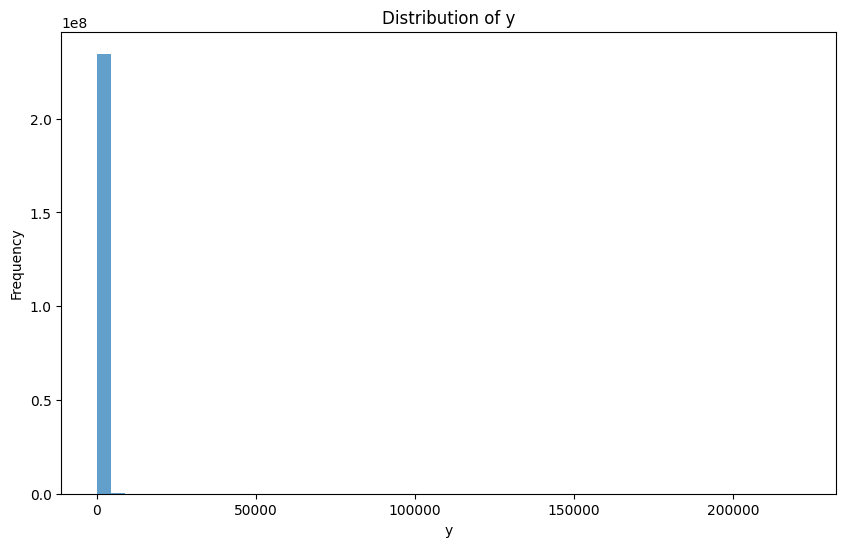

In [1]:
import polars as pl
import matplotlib.pyplot as plt

# File path to your dataset
file_path = "C:/Users/prite/Desktop/mlops-timeseries/data/raw/demand.parquet"

# Load dataset
print("Loading dataset...")
df = pl.read_parquet(file_path)

# Display a sample
print("Sample of the dataset:")
print(df.head(10))

# Check the schema
print("Schema of the dataset:")
print(df.schema)

# Summary statistics
print("Summary statistics:")
print(df.describe())

# Check the min and max for each column
print("Column-wise min and max values:")
for column in df.columns:
    print(f"{column}: Min = {df[column].min()}, Max = {df[column].max()}")

# Visualize some columns
columns_to_plot = ["y", "temperature_2m", "relative_humidity_2m"]  # Adjust based on dataset columns
for column in columns_to_plot:
    if column in df.columns:
        plt.figure(figsize=(10, 6))
        plt.hist(df[column].to_numpy(), bins=50, alpha=0.7)
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()


In [1]:
import polars as pl

# Paths to datasets
raw_data_dir = "C:/Users/prite/Desktop/mlops-timeseries/data/raw"

# Load datasets
demand = pl.read_parquet(f"{raw_data_dir}/demand.parquet")
metadata = pl.read_parquet(f"{raw_data_dir}/metadata.parquet")
weather = pl.read_parquet(f"{raw_data_dir}/weather.parquet")

# Display samples
print("Demand Dataset Sample:")
print(demand.head(10))
print("\nMetadata Dataset Sample:")
print(metadata.head(10))
print("\nWeather Dataset Sample:")
print(weather.head(10))


Demand Dataset Sample:
shape: (10, 3)
┌──────────────────┬─────────────────────┬─────┐
│ unique_id        ┆ timestamp           ┆ y   │
│ ---              ┆ ---                 ┆ --- │
│ str              ┆ datetime[ns]        ┆ f64 │
╞══════════════════╪═════════════════════╪═════╡
│ a4077c2f0ac5f939 ┆ 2012-10-12 00:30:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 01:00:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 01:30:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 02:00:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 02:30:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 03:00:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 03:30:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 04:00:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 04:30:00 ┆ 0.0 │
│ a4077c2f0ac5f939 ┆ 2012-10-12 05:00:00 ┆ 0.0 │
└──────────────────┴─────────────────────┴─────┘

Metadata Dataset Sample:
shape: (10, 11)
┌────────────┬────────────┬────────────┬────────────┬───┬───────────┬───────────┬───────────┬──────┐
│ unique_id  ┆ dataset    ┆ buildin

In [2]:
print("Demand Dataset Types:")
print(demand.dtypes)

print("\nMetadata Dataset Types:")
print(metadata.dtypes)

print("\nWeather Dataset Types:")
print(weather.dtypes)


Demand Dataset Types:
[String, Datetime(time_unit='ns', time_zone=None), Float64]

Metadata Dataset Types:
[String, String, String, String, Float64, Float64, String, String, String, Int64, String]

Weather Dataset Types:
[Datetime(time_unit='ns', time_zone=None), Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, Float32, String]


In [4]:
print("Null Counts in Demand Dataset:")
print(demand.null_count())

print("\nNull Counts in Metadata Dataset:")
print(metadata.null_count())

print("\nNull Counts in Weather Dataset:")
print(weather.null_count())


Null Counts in Demand Dataset:
shape: (1, 3)
┌───────────┬───────────┬─────────┐
│ unique_id ┆ timestamp ┆ y       │
│ ---       ┆ ---       ┆ ---     │
│ u32       ┆ u32       ┆ u32     │
╞═══════════╪═══════════╪═════════╡
│ 0         ┆ 0         ┆ 3086278 │
└───────────┴───────────┴─────────┘

Null Counts in Metadata Dataset:
shape: (1, 11)
┌───────────┬─────────┬─────────────┬─────────────┬───┬──────────┬─────────────┬────────────┬──────┐
│ unique_id ┆ dataset ┆ building_id ┆ location_id ┆ … ┆ timezone ┆ building_cl ┆ cluster_si ┆ freq │
│ ---       ┆ ---     ┆ ---         ┆ ---         ┆   ┆ ---      ┆ ass         ┆ ze         ┆ ---  │
│ u32       ┆ u32     ┆ u32         ┆ u32         ┆   ┆ u32      ┆ ---         ┆ ---        ┆ u32  │
│           ┆         ┆             ┆             ┆   ┆          ┆ u32         ┆ u32        ┆      │
╞═══════════╪═════════╪═════════════╪═════════════╪═══╪══════════╪═════════════╪════════════╪══════╡
│ 0         ┆ 0       ┆ 0           ┆ 237       

In [5]:
# Check unique_id consistency between demand and metadata
missing_ids = demand["unique_id"].filter(~demand["unique_id"].is_in(metadata["unique_id"]))
print(f"Missing unique_id in metadata: {len(missing_ids)}")

# Check location_id consistency between metadata and weather
missing_locations = metadata["location_id"].filter(~metadata["location_id"].is_in(weather["location_id"]))
print(f"Missing location_id in weather: {len(missing_locations)}")


Missing unique_id in metadata: 0
Missing location_id in weather: 0


In [6]:
# Statistical summary of demand dataset
print("Demand Dataset Summary:")
print(demand.describe())

# Statistical summary of metadata dataset
print("Metadata Dataset Summary:")
print(metadata.describe())

# Statistical summary of weather dataset
print("Weather Dataset Summary:")
print(weather.describe())


Demand Dataset Summary:
shape: (9, 4)
┌────────────┬──────────────────┬────────────────────────────┬──────────────┐
│ statistic  ┆ unique_id        ┆ timestamp                  ┆ y            │
│ ---        ┆ ---              ┆ ---                        ┆ ---          │
│ str        ┆ str              ┆ str                        ┆ f64          │
╞════════════╪══════════════════╪════════════════════════════╪══════════════╡
│ count      ┆ 237944171        ┆ 237944171                  ┆ 2.34857893e8 │
│ null_count ┆ 0                ┆ 0                          ┆ 3.086278e6   │
│ mean       ┆ null             ┆ 2013-09-06 03:14:57.996666 ┆ 44.904474    │
│ std        ┆ null             ┆ null                       ┆ 394.250414   │
│ min        ┆ 0000402b3d8bb6f6 ┆ 2011-01-01 00:30:00        ┆ 0.0          │
│ 25%        ┆ null             ┆ 2012-10-30 10:00:00        ┆ 0.077        │
│ 50%        ┆ null             ┆ 2013-05-20 05:00:00        ┆ 0.199        │
│ 75%        ┆ null       

In [8]:
import polars as pl
import logging
from pathlib import Path

logging.basicConfig(level=logging.INFO)

class ElectricityDemandProcessor:
    def __init__(self, raw_data_dir: str, processed_data_path: str, chunk_size: int = 500_000):
        self.raw_data_dir = Path(raw_data_dir)
        self.processed_data_path = Path(processed_data_path)
        self.chunk_size = chunk_size

    def detect_and_handle_outliers(self, data: pl.DataFrame, column: str):
        """
        Detect and handle outliers in the specified column using the IQR method.
        """
        logging.info("Detecting and handling outliers...")
        
        # Compute IQR
        q1, q3 = data[column].quantile(0.25), data[column].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr

        # Flag and cap outliers
        data = data.with_columns(
            pl.when((data[column] < lower_bound) | (data[column] > upper_bound))
            .then(1)
            .otherwise(0)
            .alias(f"{column}_is_outlier")
        )
        data = data.with_columns(
            pl.when(data[column] > upper_bound)
            .then(upper_bound)
            .when(data[column] < lower_bound)
            .then(lower_bound)
            .otherwise(data[column])
            .alias(column)
        )

        logging.info(f"Outliers capped for column '{column}'.")
        return data

    def process(self):
        logging.info("Starting data processing pipeline...")
        
        # Load metadata and clean nulls
        metadata_path = self.raw_data_dir / "metadata.parquet"
        metadata = pl.read_parquet(metadata_path)
        metadata = metadata.filter(metadata["location_id"].is_not_null())
        logging.info("Loaded and cleaned metadata.parquet")

        # Load weather dataset
        weather_path = self.raw_data_dir / "weather.parquet"
        weather = pl.read_parquet(weather_path)
        logging.info("Loaded weather.parquet")

        # Prepare output directory
        self.processed_data_path.parent.mkdir(parents=True, exist_ok=True)

        # Process demand dataset in chunks
        demand_path = self.raw_data_dir / "demand.parquet"
        demand_reader = pl.read_parquet(demand_path, use_pyarrow=True)

        all_chunks = []
        for i, demand_chunk in enumerate(demand_reader.iter_slices(self.chunk_size)):
            logging.info(f"Processing demand chunk {i + 1}...")
            
            # Handle nulls in demand
            demand_chunk = demand_chunk.with_columns(demand_chunk["y"].fill_null(0))
            
            # Detect and handle outliers in demand
            demand_chunk = self.detect_and_handle_outliers(demand_chunk, "y")
            
            # Join demand with metadata
            demand_chunk = demand_chunk.join(metadata, on="unique_id", how="left")
            
            # Filter weather data for relevant location_id and timestamp
            relevant_weather = weather.filter(
                weather["location_id"].is_in(demand_chunk["location_id"])
            )
            demand_chunk = demand_chunk.join(
                relevant_weather, on=["location_id", "timestamp"], how="left"
            )

            # Append processed chunk
            all_chunks.append(demand_chunk)

        # Concatenate and save all chunks to a single file
        logging.info("Saving processed data...")
        combined = pl.concat(all_chunks)
        combined.write_parquet(self.processed_data_path)
        logging.info(f"Processing complete. Data saved to {self.processed_data_path}")


if __name__ == "__main__":
    raw_data_dir = "C:/Users/prite/Desktop/mlops-timeseries/data/raw"
    processed_data_path = "C:/Users/prite/Desktop/mlops-timeseries/data/processed/processed_data.parquet"

    processor = ElectricityDemandProcessor(raw_data_dir, processed_data_path, chunk_size=500_000)
    processor.process()


INFO:root:Starting data processing pipeline...
INFO:root:Loaded and cleaned metadata.parquet
INFO:root:Loaded weather.parquet
INFO:root:Processing demand chunk 1...
INFO:root:Detecting and handling outliers...
INFO:root:Outliers capped for column 'y'.
INFO:root:Processing demand chunk 2...
INFO:root:Detecting and handling outliers...
INFO:root:Outliers capped for column 'y'.
INFO:root:Processing demand chunk 3...
INFO:root:Detecting and handling outliers...
INFO:root:Outliers capped for column 'y'.
INFO:root:Processing demand chunk 4...
INFO:root:Detecting and handling outliers...
INFO:root:Outliers capped for column 'y'.
INFO:root:Processing demand chunk 5...
INFO:root:Detecting and handling outliers...
INFO:root:Outliers capped for column 'y'.
INFO:root:Processing demand chunk 6...
INFO:root:Detecting and handling outliers...
INFO:root:Outliers capped for column 'y'.
INFO:root:Processing demand chunk 7...
INFO:root:Detecting and handling outliers...
INFO:root:Outliers capped for colu

: 

In [2]:
import pandas as pd
processed_data_path = "C:/Users/prite/Desktop/mlops-timeseries/data/processed/processed_data.parquet"
processed_data_df = pd.read_parquet(processed_data_path)


In [3]:
print(processed_data_df.info())
print(processed_data_df.head())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2944171 entries, 0 to 2944170
Data columns (total 44 columns):
 #   Column                      Dtype         
---  ------                      -----         
 0   unique_id                   object        
 1   timestamp                   datetime64[ns]
 2   y                           float64       
 3   dataset                     object        
 4   building_id                 object        
 5   location_id                 object        
 6   latitude                    float64       
 7   longitude                   float64       
 8   location                    object        
 9   timezone                    object        
 10  building_class              object        
 11  cluster_size                int64         
 12  freq                        object        
 13  temperature_2m              float32       
 14  relative_humidity_2m        float32       
 15  dew_point_2m                float32       
 16  apparent_temperatu

In [4]:
print(processed_data_df.isnull().sum())  # Null values check
print(processed_data_df.describe())     # Summary statistics


unique_id                           0
timestamp                           0
y                                   0
dataset                             0
building_id                         0
location_id                         0
latitude                            0
longitude                           0
location                            0
timezone                            0
building_class                      0
cluster_size                        0
freq                                0
temperature_2m                2208121
relative_humidity_2m          2208121
dew_point_2m                  2208121
apparent_temperature          2208121
precipitation                 2208121
rain                          2208121
snowfall                      2208121
snow_depth                    2208121
weather_code                  2208121
pressure_msl                  2208121
surface_pressure              2208121
cloud_cover                   2208121
cloud_cover_low               2208121
cloud_cover_

In [5]:
print(processed_data_df['y'].describe())  # Check the 'y' column for outliers


count    2.944171e+06
mean     3.011880e+02
std      7.594746e+02
min      0.000000e+00
25%      1.946647e+01
50%      7.441113e+01
75%      2.264753e+02
max      4.178170e+03
Name: y, dtype: float64


In [8]:
processed_data_df.shape

(2944171, 44)